<a href="https://colab.research.google.com/github/Vasyl808/deepfake_video_detection/blob/main/fakeavceleb(train_test_split)_balanced_ready.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install facenet_pytorch --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.8 MB/s eta 0:00:00


In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1abOH_th3RXci7yUrN4TWCKWTjVUTVMKv/view?usp=sharing -O FakeAVCeleb.zip

Downloading...
From (original): https://drive.google.com/uc?id=1abOH_th3RXci7yUrN4TWCKWTjVUTVMKv
From (redirected): https://drive.google.com/uc?id=1abOH_th3RXci7yUrN4TWCKWTjVUTVMKv&confirm=t&uuid=3c7712e5-24eb-4d79-abd2-63f271654a88
To: /content/FakeAVCeleb.zip
100% 6.40G/6.40G [01:42<00:00, 62.5MB/s]


In [ ]:
!unzip /content/FakeAVCeleb.zip

Показано результат, скорочений до останніх рядків (5000).
  inflating: FakeAVCeleb_v1.2/FakeVideo-RealAudio/Caucasian (American)/women/id01227/00052_id01075_wavtolip.mp4  
  inflating: FakeAVCeleb_v1.2/FakeVideo-RealAudio/Caucasian (American)/women/id01227/00052_id01216_wavtolip.mp4  
  inflating: FakeAVCeleb_v1.2/FakeVideo-RealAudio/Caucasian (American)/women/id01227/00052_id01231_XXpYdOHUF-g.mp4  
  inflating: FakeAVCeleb_v1.2/FakeVideo-RealAudio/Caucasian (American)/women/id01227/00052_id01238_wavtolip.mp4  
  inflating: FakeAVCeleb_v1.2/FakeVideo-RealAudio/Caucasian (American)/women/id01227/00052_id02466_wavtolip.mp4  
  inflating: FakeAVCeleb_v1.2/FakeVideo-RealAudio/Caucasian (American)/women/id01227/00052_id03556_wavtolip.mp4  
  inflating: FakeAVCeleb_v1.2/FakeVideo-RealAudio/Caucasian (American)/women/id01227/00052_id03605_wavtolip.mp4  
  inflating: FakeAVCeleb_v1.2/FakeVideo-RealAudio/Caucasian (American)/women/id01227/00052_id03707_pwNcRPQ5qdo.mp4  
  inflating: FakeAVCeleb

In [ ]:
import os
import random
import datetime
import sys
import itertools
import os.path
import time
import glob
import subprocess
import shutil
from pathlib import Path
from collections import Counter
import gc
import math
from typing import List, Dict, Tuple, Union

from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from facenet_pytorch import MTCNN
from torch.nn import functional
import torchvision.models as models
import cv2


import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
!rm -rf /content/face_encode_cache/*

In [ ]:
df = pd.read_csv('/content/FakeAVCeleb/meta_data.csv')

df_filtered = df[df['category'].isin(['A', 'C'])]

df_category_c = df_filtered[df_filtered['category'] == 'C']
df_category_c_unique = df_category_c.drop_duplicates(subset=['source']).head(500)

if df_category_c_unique['source'].nunique() < 500:
    raise ValueError("Недостатньо унікальних джерел у категорії 'C'.")

df_category_a = df_filtered[df_filtered['category'] == 'A'].head(500)

df_sampled = pd.concat([df_category_a, df_category_c_unique])

df_unique = df_sampled.groupby(['category', 'race', 'gender']).apply(lambda x: x.drop_duplicates(subset=['source', 'path']).head(50))
df_unique = df_unique.reset_index(drop=True)

df_unique['stratify_col'] = df_unique['category'].astype(str) + '_' + df_unique['race'] + '_' + df_unique['gender']

train_df, test_df = train_test_split(
    df_unique,
    test_size=0.2,
    random_state=42,
    stratify=df_unique['stratify_col']
)

<ipython-input-2-033f2ec14e86>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_unique = df_sampled.groupby(['category', 'race', 'gender']).apply(lambda x: x.drop_duplicates(subset=['source', 'path']).head(50))


In [ ]:
train_df = train_df.drop(columns=['stratify_col'])
test_df = test_df.drop(columns=['stratify_col'])

train_df.to_csv("train_dataset.csv", index=False)
test_df.to_csv("test_dataset.csv", index=False)

In [ ]:
train_df

,source,target1,target2,method,category,type,race,gender,path,Unnamed: 9
733,id07058,id03344,-,faceswap,C,FakeVideo-RealAudio,Asian (South),men,00010_id03344_vyNnOo6lU0o_faceswap.mp4,FakeAVCeleb/FakeVideo-RealAudio/Asian (South)/...
296,id07236,-,-,real,A,RealVideo-RealAudio,Asian (South),women,00143.mp4,FakeAVCeleb/RealVideo-RealAudio/Asian (South)/...
642,id08299,0.mp4,-,faceswap,C,FakeVideo-RealAudio,Asian (East),men,00110_0.mp4,FakeAVCeleb/FakeVideo-RealAudio/Asian (East)/m...
522,id01392,1.mp4,-,faceswap,C,FakeVideo-RealAudio,African,men,00167_1.mp4,FakeAVCeleb/FakeVideo-RealAudio/African/men/id...
984,id00823,id00395,-,faceswap,C,FakeVideo-RealAudio,Caucasian (European),women,00125_id00395_wM5kGJfTtEM_faceswap.mp4,FakeAVCeleb/FakeVideo-RealAudio/Caucasian (Eur...
...,...,...,...,...,...,...,...,...,...,...
399,id03781,-,-,real,A,RealVideo-RealAudio,Caucasian (American),women,00113.mp4,FakeAVCeleb/RealVideo-RealAudio/Caucasian (Ame...
847,id04216,0.mp4,-,faceswap,C,FakeVideo-RealAudio,Caucasian (American),men,00470_0.mp4,FakeAVCeleb/FakeVideo-RealAudio/Caucasian (Ame...
115,id02561,-,-,real,A,RealVideo-RealAudio,Asian (East),men,02561.mp4,FakeAVCeleb/RealVideo-RealAudio/Asian (East)/m...
13,id00944,-,-,real,A,RealVideo-RealAudio,African,men,00135.mp4,FakeAVCeleb/RealVideo-RealAudio/African/men/id...


In [ ]:
print("\nРозподіл за race та gender для кожного класу:")
for category in test_df['category'].unique():
    print(f"\nCategory {category}:")
    print(test_df[test_df['category'] == category][['race', 'gender']].value_counts())



Розподіл за race та gender для кожного класу:

Category C:
race                  gender
African               men       10
                      women     10
Asian (East)          men       10
                      women     10
Asian (South)         men       10
                      women     10
Caucasian (American)  men       10
                      women     10
Caucasian (European)  men       10
                      women     10
Name: count, dtype: int64

Category A:
race                  gender
African               men       10
                      women     10
Asian (East)          men       10
                      women     10
Asian (South)         men       10
                      women     10
Caucasian (American)  men       10
                      women     10
Caucasian (European)  men       10
                      women     10
Name: count, dtype: int64


In [ ]:
def create_json_from_csv(input_csv: str, output_json: str) -> None:
    df = pd.read_csv(input_csv)
    result = {}
    for _, row in df.iterrows():
        # Формування ключа з шляху
        s = '/'
        file_path = '/content/' + str(row['Unnamed: 9']) + s + row['path']

        label = row['category']


        result[file_path] = {
            'label': label
        }
    with open(output_json, 'w') as json_file:
        json.dump(result, json_file)


create_json_from_csv('train_dataset.csv', 'output_balenced_train.json')
create_json_from_csv('test_dataset.csv', 'output_balenced_test.json')

In [ ]:
with open('output_balenced_train.json', 'r') as json_file:
    data = json.load(json_file)

label_counts = Counter()

for item in data.values():
    label_counts[item['label']] += 1

for label, count in label_counts.items():
    print(f"Label: {label}, Count: {count}")


Label: C, Count: 400
Label: A, Count: 400


In [ ]:
class FaceDeepfakeDataset(torch.utils.data.Dataset):
    def __init__(self, folders, n_frames=None, train=True, device=None, cache_folder='/content/face_encode_cache'):
        self.n_frames = n_frames
        self.videos = []
        self.train = train
        self.device = device if device is not None else torch.device("cpu")
        self.cache_folder = cache_folder
        self.detector = MTCNN(device=device, post_process=False)

        for i in range(len(folders)):
            if train:
                with open('/content/output_balenced_train.json') as f:
                    videos = json.load(f)
                    videos = [(video, metadata) for (video, metadata) in videos.items()]
                    self.videos += videos
            else:
                self.videos += glob.glob(folders[i] + "/*.mp4")

        if self.cache_folder:
            os.makedirs(self.cache_folder, exist_ok=True)

    def __process_frame(self, frame, prev_frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        boxes, _ = self.detector.detect(frame, landmarks=False)

        if boxes is None:
            face = prev_frame
            face = cv2.resize(face, (224, 224))
            face = torch.from_numpy(face).permute(2, 0, 1).float() / 255.0
            return face
        else:
            box = boxes[0]

            width = box[2] - box[0]
            height = box[3] - box[1]
            expand_x = width * 0.3 / 2
            expand_y = height * 0.3 / 2
            x1 = max(int(box[0] - expand_x), 0)
            y1 = max(int(box[1] - expand_y), 0)
            x2 = min(int(box[2] + expand_x), frame.shape[1])
            y2 = min(int(box[3] + expand_y), frame.shape[0])

            face = frame[y1:y2, x1:x2]
            face = cv2.resize(face, (224, 224))

            face = torch.from_numpy(face).permute(2, 0, 1).float() / 255.0

        return face

    def __pad_or_trim_frames(self, frames):
        if len(frames) == self.n_frames:
            return frames
        elif len(frames) < self.n_frames:
            frames += [frames[-1]] * (self.n_frames - len(frames))
        elif len(frames) > self.n_frames:
            frames = frames[:self.n_frames]
        return frames

    def __getitem__(self, n):
        if self.train:
            video, metadata = self.videos[n]
        else:
            video = self.videos[n]

        cache_file = None
        if self.cache_folder:
            video_name = video.replace('.mp4', '_frames.pt')
            video_name = video_name.replace(' ', '_')
            video_name = video_name.replace('/', '_')
            cache_file = os.path.join(self.cache_folder, video_name)
            if os.path.exists(cache_file):
                frames = torch.load(cache_file).to(self.device)
                if self.train:
                    label = 0.0
                    if metadata['label'] == 'C' or metadata['label'] == 'D':
                        label = 1.0
                    return frames, torch.FloatTensor([label]).to(self.device)
                else:
                    return frames

        if os.path.islink(video):
            video = os.readlink(video)

        cap = cv2.VideoCapture(video)
        prev_frame = torch.zeros((3, 224, 224))
        frames = []
        for _ in range(self.n_frames):
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(self.__process_frame(frame, prev_frame))
            prev_frame = frame
        cap.release()

        frames = self.__pad_or_trim_frames(frames)
        frames = torch.stack(frames).to(self.device)

        if cache_file:
            torch.save(frames, cache_file)

        if self.train:
            label = 0.0
            if metadata['label'] == 'C' or metadata['label'] == 'D':
                label = 1.0
            return frames, torch.FloatTensor([label]).to(self.device)
        else:
            return frames

    def __len__(self):
        return len(self.videos)

Label: tensor([1.], device='cuda:0')


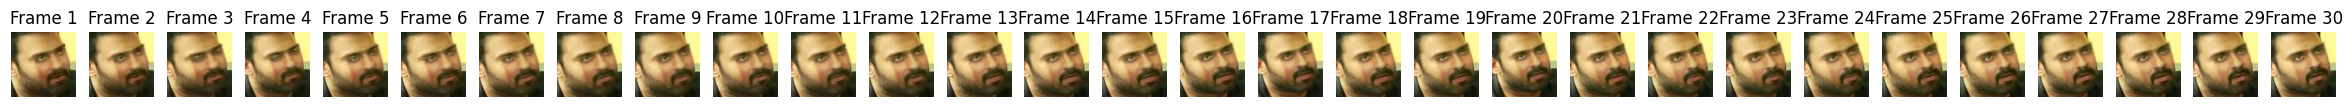

In [ ]:
def test_face_dataset():
    TRAIN_FOLDERS = ['/content/FakeAVCeleb/']
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataset = FaceDeepfakeDataset(TRAIN_FOLDERS, n_frames=30, train=True, device=device)

    for i, batch in enumerate(dataset):
        frames, label = batch
        print(f"Label: {label}")

        if frames.size() != torch.Size([30, 3, 224, 224]):
            print(f"Unexpected frame size: {frames.size()}")

        fig, axes = plt.subplots(1, 30, figsize=(30, 10))

        for j in range(30):
            ax = axes[j]
            frame = frames[j].cpu().permute(1, 2, 0).numpy()
            ax.imshow(frame)
            ax.set_title(f"Frame {j+1}")
            ax.axis('off')

        plt.show()
        break

test_face_dataset()

In [ ]:
class FaceDeepfakeDatasetTest(torch.utils.data.Dataset):
    def __init__(self, folders, n_frames=None, train=True, device=None, cache_folder=None):
        self.n_frames = n_frames
        self.videos = []
        self.train = train
        self.device = device if device is not None else torch.device("cpu")
        self.cache_folder = cache_folder
        self.detector = MTCNN(device=device, post_process=False)

        # Load video paths
        for i in range(len(folders)):
            if train:
                with open('/content/output_balenced_test.json') as f:
                    videos = json.load(f)
                    videos = [(video, metadata) for (video, metadata) in videos.items()]
                    self.videos += videos
            else:
                self.videos += glob.glob(folders[i] + "/*.mp4")

        if self.cache_folder:
            os.makedirs(self.cache_folder, exist_ok=True)

    def __process_frame(self, frame, prev_frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        boxes, _ = self.detector.detect(frame, landmarks=False)  # Отримуємо координати обличчя

        if boxes is None:
            face = prev_frame
            face = cv2.resize(face, (224, 224))
            face = torch.from_numpy(face).permute(2, 0, 1).float() / 255.0
            return face
        else:
            # Беремо перше обличчя (якщо знайдено кілька)
            box = boxes[0]

            # Розширюємо рамку на 30%
            width = box[2] - box[0]
            height = box[3] - box[1]
            expand_x = width * 0.3 / 2
            expand_y = height * 0.3 / 2
            x1 = max(int(box[0] - expand_x), 0)
            y1 = max(int(box[1] - expand_y), 0)
            x2 = min(int(box[2] + expand_x), frame.shape[1])
            y2 = min(int(box[3] + expand_y), frame.shape[0])

            # Обрізаємо зображення за новими координатами
            face = frame[y1:y2, x1:x2]
            face = cv2.resize(face, (224, 224))  # Масштабуємо до 300x300

            # Перетворюємо на тензор і нормалізуємо
            face = torch.from_numpy(face).permute(2, 0, 1).float() / 255.0

        return face

    def __pad_or_trim_frames(self, frames):
        if len(frames) == self.n_frames:
            return frames
        elif len(frames) < self.n_frames:
            # Дублюємо останній кадр поки не досягнемо необхідної кількості
            frames += [frames[-1]] * (self.n_frames - len(frames))
        elif len(frames) > self.n_frames:
            # Залишаємо тільки перші n_frames кадрів
            frames = frames[:self.n_frames]
        return frames

    def __getitem__(self, n):
        if self.train:
            video, metadata = self.videos[n]
        else:
            video = self.videos[n]

        # Check if cached frames exist
        cache_file = None
        if self.cache_folder:
            video_name = video.replace('.mp4', '_frames.pt')
            video_name = video_name.replace(' ', '_')
            video_name = video_name.replace('/', '_')
            cache_file = os.path.join(self.cache_folder, video_name)
            if os.path.exists(cache_file):
                frames = torch.load(cache_file).to(self.device)
                if self.train:
                    label = 0.0
                    if metadata['label'] == 'C' or metadata['label'] == 'D':
                        label = 1.0
                    return frames, torch.FloatTensor([label]).to(self.device)
                else:
                    return frames

        # Processing video frames
        if os.path.islink(video):
            video = os.readlink(video)

        cap = cv2.VideoCapture(video)
        prev_frame = torch.zeros((3, 224, 224))
        frames = []
        for _ in range(self.n_frames):
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(self.__process_frame(frame, prev_frame))
            prev_frame = frame
        cap.release()

        # Pad or trim frames to ensure consistent length
        frames = self.__pad_or_trim_frames(frames)
        frames = torch.stack(frames).to(self.device)

        # Cache processed frames
        if cache_file:
            torch.save(frames, cache_file)

        # Return data
        if self.train:
            label = 0.0
            if metadata['label'] == 'C' or metadata['label'] == 'D':
                label = 1.0
            return frames, torch.FloatTensor([label]).to(self.device)
        else:
            return frames

    def __len__(self):
        return len(self.videos)

Label: tensor([1.], device='cuda:0')


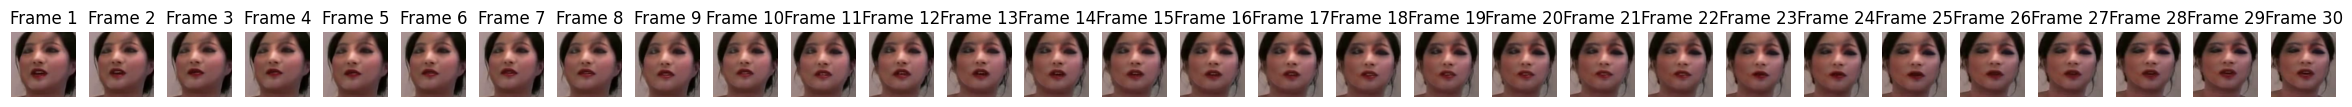

In [ ]:
def test_face_dataset():
    TRAIN_FOLDERS = ['/content/fake_videos/train']
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    dataset = FaceDeepfakeDatasetTest(TRAIN_FOLDERS, n_frames=30, train=True, device=device, cache_folder=None)

    # Одержуємо перший батч
    for i, batch in enumerate(dataset):
        frames, label = batch
        print(f"Label: {label}")

        # Перевіряємо розмір кадрів
        if frames.size() != torch.Size([30, 3, 224, 224]):
            print(f"Unexpected frame size: {frames.size()}")

        # Візуалізуємо перші два кадри
        fig, axes = plt.subplots(1, 30, figsize=(30, 10))

        for j in range(30):
            ax = axes[j]
            frame = frames[j].cpu().permute(1, 2, 0).numpy()  # Перетворюємо з CHW в HWC і конвертуємо в NumPy
            ax.imshow(frame)  # Виводимо зображення
            ax.set_title(f"Frame {j+1}")
            ax.axis('off')

        plt.show()
        break  # Призупиняємо після першого батчу

test_face_dataset()

In [ ]:
class CNNLSTMClassifier(nn.Module):
    def __init__(self,
                 n_linear_hidden,
                 lstm_hidden_dim,
                 num_lstm_layers,
                 dropout
                 ):
        super(CNNLSTMClassifier, self).__init__()

        self.cnn = models.efficientnet_b7(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(self.cnn.children())[:-1], nn.AdaptiveAvgPool2d((1, 1)))

        for param in self.feature_extractor.parameters():
            param.requires_grad = False

        self.feature_output_size = 2560

        self.lstm = nn.LSTM(input_size=self.feature_output_size,
                            hidden_size=lstm_hidden_dim,
                            num_layers=num_lstm_layers,
                            dropout=dropout,
                            batch_first=True,
                            bidirectional=True)

        self.fc1 = nn.Linear(2 * lstm_hidden_dim, n_linear_hidden)
        self.fc2 = nn.Linear(n_linear_hidden, 1)

    def forward(self, vid_frames):
        batch_size, num_frames, channels, height, width = vid_frames.shape
        vid_frames = vid_frames.view(batch_size * num_frames, channels, height, width)

        with torch.no_grad():
            vid_features = self.feature_extractor(vid_frames)

        vid_features = vid_features.view(batch_size, num_frames, -1)  # (batch_size, num_frames, feature_output_size)

        lstm_out, _ = self.lstm(vid_features)

        lstm_out = lstm_out[:, -1, :]

        x = torch.relu(self.fc1(lstm_out))
        x = self.fc2(x)

        return x

In [ ]:
hyperparameters: dict[str: Union[int, float, list]] = {
    'n_linear_hidden': 32,
    'lstm_hidden_dim': 64,
    'num_lstm_layers': 2,
    'dropout': 0.3,
    'n_frames': 30,
    'batch_size': 2,
    'lr': 0.001,
    'num_epochs': 10,
    'gamma': 0.1,
    'milestones': [4, 6, 10]
}

In [ ]:
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()


def plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()

    plt.show()


def plot_confusion_matrix_final(all_labels, all_preds, title):
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

In [ ]:
def train_model(model, hparms: dict[str, Union[int, float]], path_train: str, path_test: str, device, name: str, checkpoint_path: str = None):
    batch_size = hparms['batch_size']
    num_epochs = hparms['num_epochs']
    n_frames = hparms['n_frames']
    lr = hparms['lr']

    gamma = hparms['gamma']
    milestones = hparms['milestones']

    model.to(device)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

    train_dataset = FaceDeepfakeDataset([''],  n_frames=n_frames, device=device, cache_folder="face_encode_cache")
    test_dataset = FaceDeepfakeDatasetTest([''], n_frames=n_frames, device=device, cache_folder="face_encode_cache")

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    start_time = datetime.datetime.now()
    print(f'Start time: {start_time}, using device: {device}')

    best_loss = np.inf
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    epoch_times = []

    if checkpoint_path:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
    else:
        start_epoch = 0

    for epoch in range(start_epoch, num_epochs):
        epoch_start_time = time.time()
        epoch_t_loss, epoch_v_loss = 0, 0
        t_count, t_count_wrong = 0, 0
        all_train_labels, all_train_preds = [], []
        test_probs = []

        model.train()
        torch.cuda.empty_cache()
        gc.collect()

        for video_data, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} Training", leave=False):
            video_data, labels = video_data.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(video_data)
            loss = criterion(torch.sigmoid(output), labels)

            epoch_t_loss += loss.item()
            output = torch.sigmoid(output).round()
            n_wrong = (labels - output).abs().sum().item()
            t_count_wrong += n_wrong
            t_count += labels.shape[0]

            all_train_labels.extend(labels.detach().cpu().numpy())
            all_train_preds.extend(output.detach().cpu().numpy())

            loss.backward()
            optimizer.step()

            torch.cuda.empty_cache()
            gc.collect()

        train_loss = epoch_t_loss / len(train_loader)
        train_accuracy = (t_count - t_count_wrong) / t_count
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        torch.cuda.empty_cache()
        gc.collect()
        all_val_labels, all_val_preds = [], []
        with torch.no_grad():
            for video_data, labels in tqdm(val_loader, desc="Validation", leave=False):
                video_data, labels = video_data.to(device), labels.to(device)

                output = model(video_data)
                output_probs = torch.sigmoid(output)
                test_probs.extend(output_probs.cpu().numpy())

                loss = criterion(torch.sigmoid(output), labels)
                epoch_v_loss += loss.item()

                output = torch.sigmoid(output).round()
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(output.cpu().numpy())

                torch.cuda.empty_cache()
                gc.collect()

        val_loss = epoch_v_loss / len(val_loader)
        val_accuracy = np.sum(np.array(all_val_labels) == np.array(all_val_preds)) / len(all_val_labels)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        epoch_exec_time = time.time() - epoch_start_time
        epoch_times.append(epoch_exec_time)
        print(f'Epoch {epoch + 1}/{num_epochs} - Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}')
        print(f'Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.4f}, Time: {epoch_exec_time:.2f}s')

        scheduler.step()

        torch.save({
                    'model_state_dict': model.state_dict(),
                     'optimizer_state_dict': optimizer.state_dict(),
                     'scheduler_state_dict': scheduler.state_dict(),
                      'epoch': epoch + 1
                      }, f'/content/drive/MyDrive/experiments/best_{name}_lstm_checkpoint_epoch_{epoch + 1}.pt'
         )

    print(f'Training completed in: {str(datetime.datetime.now() - start_time)}')

    plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    print("Train Classification Report:")
    print(classification_report(all_train_labels, all_train_preds))
    plot_confusion_matrix_final(all_train_labels, all_train_preds, 'Train')

    print("Validation Classification Report:")
    print(classification_report(all_val_labels, all_val_preds))
    plot_confusion_matrix_final(all_val_labels, all_val_preds, 'Validation')
    train_auc = roc_auc_score(all_val_labels, test_probs)
    print(f'Train AUC: {train_auc}')

In [ ]:
class MyResNeXt(models.resnet.ResNet):
    def __init__(self, checkpoint_path):
        super(MyResNeXt, self).__init__(block=models.resnet.Bottleneck,
                                        layers=[3, 4, 6, 3],
                                        groups=32,
                                        width_per_group=4)
        # Завантаження попередньо натренованих ваг
        checkpoint = torch.load(checkpoint_path)
        self.load_state_dict(checkpoint)

        # Замінюємо існуючий FC шар новим
        self.fc = nn.Identity()  # Залишаємо фічерний екстрактор без класифікаційного шару


class ResNetLSTMClassifier(nn.Module):
    def __init__(self,
                 n_linear_hidden,
                 lstm_hidden_dim,
                 num_lstm_layers,
                 dropout
                 ):
        super(ResNetLSTMClassifier, self).__init__()

        # Завантаження модифікованого ResNeXt
        self.cnn = MyResNeXt('resnext50_32x4d-7cdf4587.pth')

        # Розмір виходу ResNeXt (2048 для resnext50_32x4d)
        self.feature_output_size = 2048

        # Заморожуємо ранні шари, залишаючи лише частину для навчання
        self.freeze_until("layer4.0.conv1.weight")

        # Додаємо шар для витягування глобальних ознак
        self.feature_extractor = nn.Sequential(
            *list(self.cnn.children())[:-2],  # Використовуємо всі шари до передостаннього
            nn.AdaptiveAvgPool2d((1, 1))  # Адаптивне середнє значення
        )

        # LSTM для обробки послідовності ознак кожного кадру
        self.lstm = nn.LSTM(input_size=self.feature_output_size,
                            hidden_size=lstm_hidden_dim,
                            num_layers=num_lstm_layers,
                            dropout=dropout,
                            batch_first=True,
                            bidirectional=True)

        # Повнозв'язні шари для класифікації
        self.fc1 = nn.Linear(2 * lstm_hidden_dim, n_linear_hidden)  # множимо на 2 через bidirectional LSTM
        self.fc2 = nn.Linear(n_linear_hidden, 1)

    def freeze_until(self, param_name):
        """Заморожує всі шари до `param_name`, включно."""
        found_name = False
        for name, params in self.cnn.named_parameters():
            if name == param_name:
                found_name = True
            params.requires_grad = found_name

    def forward(self, vid_frames):
        # Витягання ознак для кожного кадру
        batch_size, num_frames, channels, height, width = vid_frames.shape
        vid_frames = vid_frames.view(batch_size * num_frames, channels, height, width)

        # Використовуємо ResNeXt як фічерний екстрактор
        vid_features = self.cnn(vid_frames)  # (batch_size*num_frames, feature_output_size, 1, 1)

        vid_features = vid_features.view(batch_size, num_frames, -1)  # (batch_size, num_frames, feature_output_size)

        lstm_out, _ = self.lstm(vid_features)

        lstm_out = torch.mean(lstm_out, dim=1)

        x = torch.relu(self.fc1(lstm_out))
        x = self.fc2(x)

        return x

Start time: 2024-11-22 21:22:02.341339, using device: cuda


Epoch 1/10 - Train loss: 0.5925, Train accuracy: 0.6887
Validation loss: 0.4194, Validation accuracy: 0.8600, Time: 362.08s


Epoch 2/10 - Train loss: 0.4827, Train accuracy: 0.7688
Validation loss: 0.3429, Validation accuracy: 0.8650, Time: 364.34s


Epoch 3/10 - Train loss: 0.3766, Train accuracy: 0.8450
Validation loss: 0.3714, Validation accuracy: 0.8550, Time: 366.80s


Epoch 4/10 - Train loss: 0.3226, Train accuracy: 0.8762
Validation loss: 0.2233, Validation accuracy: 0.9200, Time: 368.70s


Epoch 5/10 - Train loss: 0.2255, Train accuracy: 0.9125
Validation loss: 0.2250, Validation accuracy: 0.9150, Time: 370.06s


Epoch 6/10 - Train loss: 0.2159, Train accuracy: 0.9337
Validation loss: 0.2362, Validation accuracy: 0.9150, Time: 371.71s


Epoch 7/10 - Train loss: 0.1898, Train accuracy: 0.9287
Validation loss: 0.2308, Validation accuracy: 0.9150, Time: 372.12s


Epoch 8/10 - Train loss: 0.2000, Train accuracy: 0.9275
Validation loss: 0.2144, Validation accuracy: 0.9250, Time: 377.63s


Epoch 9/10 - Train loss: 0.1775, Train accuracy: 0.9413
Validation loss: 0.2117, Validation accuracy: 0.9300, Time: 378.89s


Epoch 10/10 - Train loss: 0.1802, Train accuracy: 0.9400
Validation loss: 0.2172, Validation accuracy: 0.9250, Time: 376.92s
Training completed in: 1:02:00.126861


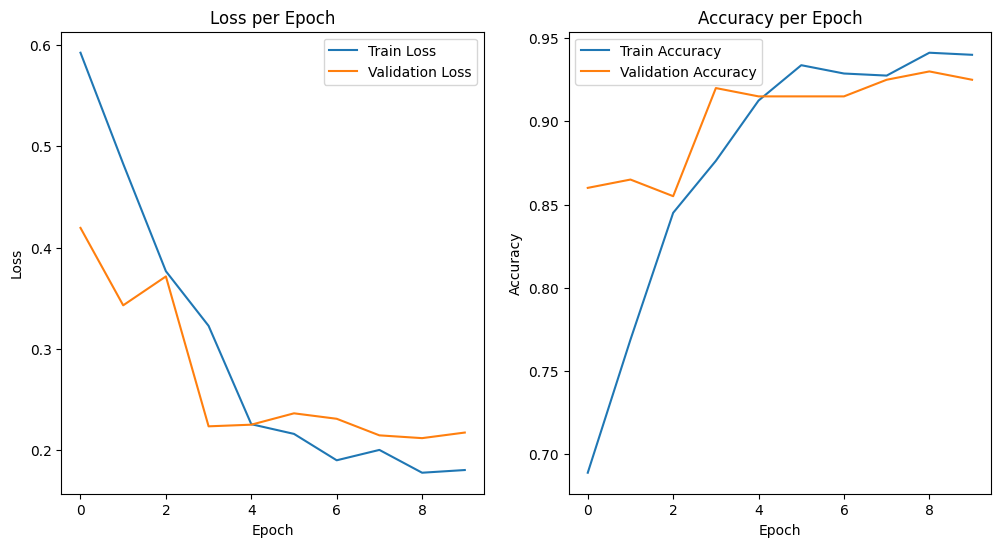

Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94       400
         1.0       0.97      0.91      0.94       400

    accuracy                           0.94       800
   macro avg       0.94      0.94      0.94       800
weighted avg       0.94      0.94      0.94       800



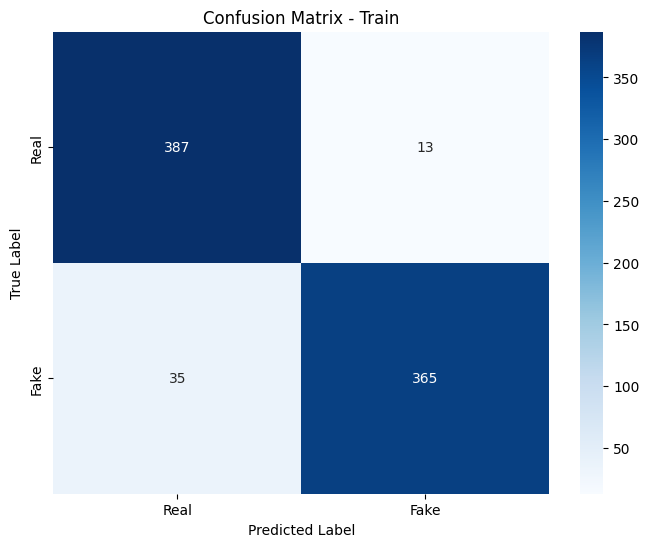

Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93       100
         1.0       0.96      0.89      0.92       100

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.92       200
weighted avg       0.93      0.93      0.92       200



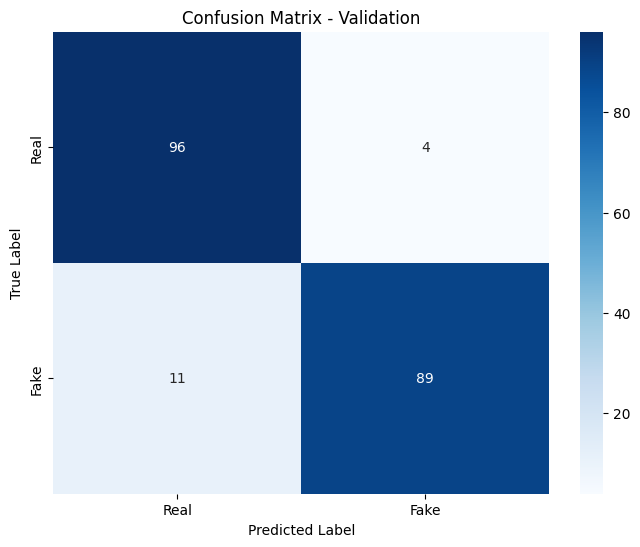

Train AUC: 0.9530000000000001


In [ ]:
model = ResNetLSTMClassifier(
    n_linear_hidden=hyperparameters['n_linear_hidden'],
    lstm_hidden_dim=hyperparameters['lstm_hidden_dim'],
    num_lstm_layers=hyperparameters['num_lstm_layers'],
    dropout=hyperparameters['dropout']
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_model(model, hyperparameters, 'output_balenced_train.json', 'output_balenced_test.json', device, 'DeepFakeDetector')